<a href="https://colab.research.google.com/github/applloP/rankpredictor/blob/main/Rocket_League_Rank_Predictor_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np

training_data = pd.read_csv('../content/sample_data/thingyv3.csv')

features = ['shooting percentage', 'bpm',
       'avg boost amount', 'amount collected', 'amount collected big pads',
       'amount collected small pads', 'count collected big pads',
       'count collected small pads', 'amount stolen', 'amount stolen big pads',
       'amount stolen small pads', 'count stolen big pads',
       'count stolen small pads', '0 boost time', '100 boost time',
       'amount used while supersonic', 'amount overfill total',
       'amount overfill stolen', 'avg speed', 'total distance',
       'time slow speed', 'percentage slow speed', 'time boost speed',
       'percentage boost speed', 'time supersonic speed',
       'percentage supersonic speed', 'time on ground', 'percentage on ground',
       'time low in air', 'percentage low in air', 'time high in air',
       'percentage high in air', 'time powerslide', 'avg powerslide time',
       'count powerslide', 'time most back', 'time most forward',
       'avg distance to ball', 'avg distance to ball has possession',
       'avg distance to ball no possession', 'time behind ball',
       'percentage behind ball', 'time in front of ball',
       'percentage in front of ball', 'time defensive half',
       'percentage defensive half', 'time offensive half',
       'percentage offensive half', 'time defensive third',
       'percentage defensive third', 'time neutral third',
       'percentage neutral third', 'time offensive third',
       'percentage offensive third', 'demos inflicted', 'demos taken', 'rank']

testing_features = features[0:-1]

rank_dict = {"Bronze I": 1,
              "Bronze II": 2,
              "Bronze III": 3,
              "Silver I": 4,
              "Silver II": 5,
              "Silver III": 6,
              "Gold I": 7,
              "Gold II": 8,
              "Gold III": 9,
              "Platinum I": 10,
              "Platinum II": 11,
              "Platinum III": 12,
              "Diamond I": 13,
              "Diamond II": 14,
              "Diamond III": 15,
              "Champion I": 16,
              "Champion II": 17,
              "Champion III": 18,
              "Grand Champion I": 19,
              "Grand Champion II": 20,
              "Grand Champion III": 21,
              "Supersonic Legend": 22}

dict_rank = {value : key for (key, value) in rank_dict.items()}

training_data["rank"].replace(rank_dict, inplace=True)

df_train = training_data.sample(frac=0.7, random_state=0)
df_valid = training_data.drop(df_train.index)

df_train = df_train[features]
df_valid = df_train[features]

# Split features and target
X_train = df_train.drop('rank', axis=1)
X_valid = df_valid.drop('rank', axis=1)
y_train = df_train['rank']
y_valid = df_valid['rank']

# Scale to [0, 1]
max_ = X_train.max(axis=0)
min_ = X_train.min(axis=0)
X_train = (X_train - min_) / (max_ - min_)
X_valid = (X_valid - min_) / (max_ - min_)

X_train.describe()

,shooting percentage,bpm,avg boost amount,amount collected,amount collected big pads,amount collected small pads,count collected big pads,count collected small pads,amount stolen,amount stolen big pads,amount stolen small pads,count stolen big pads,count stolen small pads,0 boost time,100 boost time,amount used while supersonic,amount overfill total,amount overfill stolen,avg speed,total distance,time slow speed,percentage slow speed,time boost speed,percentage boost speed,time supersonic speed,percentage supersonic speed,time on ground,percentage on ground,time low in air,percentage low in air,time high in air,percentage high in air,time powerslide,avg powerslide time,count powerslide,time most back,time most forward,avg distance to ball,avg distance to ball has possession,avg distance to ball no possession,time behind ball,percentage behind ball,time in front of ball,percentage in front of ball,time defensive half,percentage defensive half,time offensive half,percentage offensive half,time defensive third,percentage defensive third,time neutral third,percentage neutral third,time offensive third,percentage offensive third,demos inflicted,demos taken
count,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000,4166.000000
mean,0.166624,0.474135,0.556133,0.314250,0.310193,0.299390,0.311536,0.294629,0.240775,0.187725,0.203173,0.175756,0.243591,0.236864,0.247932,0.127013,0.249479,0.135933,0.556935,0.389334,0.374182,0.458057,0.391237,0.416321,0.199390,0.300536,0.426526,0.561341,0.393483,0.397609,0.187589,0.230912,0.192754,0.075683,0.211825,0.288429,0.347234,0.394317,0.372430,0.412112,0.446544,0.706879,0.348756,0.293121,0.422488,0.452264,0.385522,0.547736,0.357260,0.355901,0.404953,0.556420,0.367452,0.414023,0.071171,0.096495
std,0.197079,0.153232,0.098323,0.122932,0.134026,0.120441,0.130627,0.116429,0.142820,0.151216,0.106361,0.135304,0.119288,0.144552,0.135367,0.094588,0.148160,0.147856,0.140985,0.110253,0.121881,0.154896,0.124616,0.101684,0.119068,0.157578,0.120211,0.089523,0.119584,0.076440,0.134439,0.155594,0.117091,0.057321,0.158339,0.098894,0.109367,0.109059,0.095037,0.106314,0.118896,0.083097,0.114304,0.083097,0.120640,0.119978,0.126717,0.119978,0.108296,0.108298,0.120548,0.092935,0.137998,0.121093,0.107273,0.133831
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.369945,0.498665,0.230788,0.215607,0.219706,0.224490,0.219178,0.137389,0.081178,0.128940,0.066667,0.160000,0.132187,0.153953,0.059394,0.139594,0.016129,0.461032,0.349437,0.300564,0.345498,0.321941,0.351627,0.109278,0.178787,0.373758,0.497468,0.329343,0.349955,0.086746,0.111943,0.112114,0.047210,0.087629,0.229630,0.286726,0.325469,0.310987,0.343609,0.402928,0.656966,0.286101,0.240220,0.369194,0.373818,0.312560,0.471399,0.298070,0.281635,0.343985,0.497661,0.277843,0.335380,0.000000,0.000000
50%,0.118050,0.479779,0.562982,0.311460,0.306815,0.289142,0.306122,0.287671,0.221121,0.165031,0.189112,0.133333,0.24000

Epoch 1/100
9/9 [==============================] - 1s 41ms/step - loss: 10.0644 - val_loss: 6.1460
Epoch 2/100
9/9 [==============================] - 0s 21ms/step - loss: 4.7290 - val_loss: 4.5075
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 4.0295 - val_loss: 2.8634
Epoch 4/100
9/9 [==============================] - 0s 16ms/step - loss: 2.8728 - val_loss: 2.4531
Epoch 5/100
9/9 [==============================] - 0s 15ms/step - loss: 2.4307 - val_loss: 2.1649
Epoch 6/100
9/9 [==============================] - 0s 15ms/step - loss: 2.1834 - val_loss: 2.1334
Epoch 7/100
9/9 [==============================] - 0s 15ms/step - loss: 2.1984 - val_loss: 2.1247
Epoch 8/100
9/9 [==============================] - 0s 14ms/step - loss: 2.1101 - val_loss: 1.9789
Epoch 9/100
9/9 [==============================] - 0s 15ms/step - loss: 2.0479 - val_loss: 1.9249
Epoch 10/100
9/9 [==============================] - 0s 15ms/step - loss: 2.0478 - val_loss: 1.9438
Epoch 11/100
9/9 [

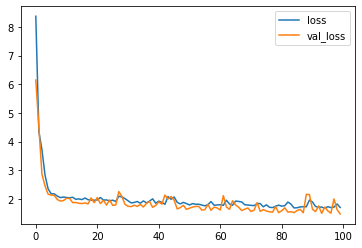

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

tf.device('/device:GPU:0')

early_stopping = callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(2048, activation='relu', input_shape=[56]),
    layers.Dropout(0.3),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=100,
    callbacks=[early_stopping]
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [31]:
import io
import math
id = 'cdd4118a-596f-4052-a255-1dc3de8a2280-players.csv'

players = pd.read_csv('../content/sample_data/{}'.format(id),sep=';')

final = players[testing_features]

# Scale to [0, 1]
final = (final - min_) / (max_ - min_)

preds = model.predict(final)

pd.DataFrame({'predicted': [dict_rank[round(item[0])] for item in preds],'name': players['player name']})

,predicted,name
0,Platinum III,DefyTheWay
1,Champion III,papi carty
2,Platinum III,gabyelpapi
3,Diamond I,appllol
4,Platinum II,Invadum
5,Platinum III,P1zye
